## Sucrose droplet analysis

### Load tools

In [2]:
%pylab inline
import h5py
import msi.utils.eval as e
import msi.utils.mie as mie
import msi.utils.particle_transmission as pt
pt.test_fraction_of_gaussian_area()
import os, sys, shutil
import pickle
import seaborn as sns
from scipy.optimize import least_squares
from scipy.special import erf

Populating the interactive namespace from numpy and matplotlib


/Users/max.hantke/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Copy unavailable files

In [3]:
#davinci_mount = "/"
davinci_mount = "/Users/max.hantke/davinci/"

suc_fn = "suc_data.h5"
suc_location = os.path.join(davinci_mount, "home/hantke/src/msi/notebooks/sucrose")
if not os.path.exists(suc_fn):
    shutil.copy(os.path.join(suc_location, suc_fn), suc_fn)
    print('copied %s' % suc_fn)
else:
    print('found %s' % suc_fn)    
    
vel_esi_fn = "velocities_fit_z9.4_p1.1.p"
vel_esi_location = os.path.join(davinci_mount, "home/hantke/src/msi/notebooks/free_jet")
vel_esi_src = os.path.join(vel_esi_location, vel_esi_fn)
if not os.path.exists(vel_esi_fn):
    shutil.copy(vel_esi_src, vel_esi_fn)
    print('copied %s' % vel_esi_fn)
else:
    print('found %s' % vel_esi_fn)    
    
vel_gdvn_fn = "velocities_fit_z8.4_p1.8.p"
vel_gdvn_location = os.path.join(davinci_mount, "home/hantke/src/msi/notebooks/free_jet")
vel_gdvn_src = os.path.join(vel_gdvn_location, vel_gdvn_fn)
if not os.path.exists(vel_gdvn_fn):
    shutil.copy(vel_gdvn_src, vel_gdvn_fn)
    print('copied %s' % vel_gdvn_fn)
else:
    print('found %s' % vel_gdvn_fn)    

found suc_data.h5
found velocities_fit_z9.4_p1.1.p
found velocities_fit_z8.4_p1.8.p


### Set constants

In [4]:
adu_per_photon = e.adu_per_photon["Hamamatsu-C11440-22CU"]
# Focus
# Focus
cx = 1040
cy = 1030

focus_sigma = 235
I_focus = lambda x,y: exp(-((x-cx)**2+(y-cy)**2)/focus_sigma**2)
L = focus_sigma * 2
# Imaging scales
p_cam = e.pixel_size["Hamamatsu-C11440-22CU"]
p_img = e.pix_to_m(p_cam, 6000, 2)
pix_to_um = lambda n_pix: n_pix * p_img / 1E-6
pix_to_m_per_sec = lambda n_pix, delay_ns: pix_to_um(n_pix) * 1E-6 / (delay_ns * 1E-9)

ray2nm = {"ESI" : lambda dRay: mie.ray2nm(dRay, "201605", mie.n_suc),
          "GDVN" : lambda dRay: mie.ray2nm(dRay, "201612", mie.n_suc)}

### Load pre-processed data

In [5]:
try:
    data.close()
except:
    pass
data = h5py.File(suc_fn, "r")

### Load velocity fits

In [6]:
velocity = {}
with open(vel_esi_fn, "r") as f:
    (v0_fit_esi, sx_fit_esi) = pickle.load(f)
velocity["ESI"] = lambda s: v0_fit_esi*exp(-s/sx_fit_esi)     
with open(vel_gdvn_fn, "r") as f:
    (v0_fit_gdvn, sx_fit_gdvn) = pickle.load(f)
velocity["GDVN"] = lambda s: v0_fit_gdvn*exp(-s/sx_fit_gdvn)   

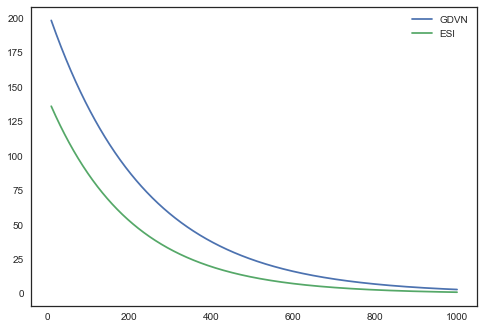

In [7]:
for source, v in velocity.items():
    _s = linspace(10., 1000., 1000)
    plot(_s, v(_s), label=source)
legend()

### Select peaks

In [8]:
data_sel = {}

for source in data:
    #print source
    data_sel[source] = {}
    for conc in data[source]:
        #print conc
        data_sel[source][conc] = {}
        for ds_name in sorted(data[source][str(conc)].keys()):

            #print ds_name
            
            # Load data
            data_ds = data[source][str(conc)][ds_name]

            bg_values = asarray(data_ds["image1"])[:,:50]
            #print "BG:", bg_values.min(), bg_values.mean(), bg_values.max()
            bg = bg_values.mean() * 317 # 317 is the number of pixels in a circular window of size 21    
        
            I = (asarray(data_ds["I_f"]) - bg) / data_ds["pulse_energy_x_transmission"] / adu_per_photon
            sat = asarray(data_ds["sat"]) == 1
            #print "Fraction saturated: %e" % (sat.sum()/float(sat.size))
        
            x = asarray(data_ds["x_f"])
            y = asarray(data_ds["y_f"])
            xoff = data_ds["conf"]["raw"]["xmin"].value
            yoff = data_ds["conf"]["raw"]["ymin"].value
            
            I /= I_focus(x+xoff, y+yoff)
            
            dist = asarray(data_ds["dists_neighbor_f"])

            # Select peaks
            
            # VALID
            sel_valid = (I >= 0) * (x >= 0) * (y >= 0)
            
            # AREA
            x_middle = cx-xoff
            y_middle = cy-yoff
            sel_area = (abs(x-x_middle) <= L/2.) * (abs(y-y_middle) <= L/2.)
            
            # NEAREST NEIGHBOUR DISTANCE
            min_dist = data_ds["conf"]["analyse"]["window_size"].value * 4
            sel_dist = dist <= min_dist
        
            # SIGNAL
            peak_score = asarray(data_ds["peak_score_f"])
            sel_score = peak_score > 5
        
            # DISLOCATION FROM MAX
            dislocation = asarray(data_ds["dislocation_f"])
            sel_dislocation = ones(shape=sel_valid.shape, dtype=bool) #dislocation < 2
    
            # Combine selections
            sel = sel_valid * sel_area * sel_dist * sel_score * sel_dislocation
        
            #print "Combined selection: %f" % sel.mean()

            data_sel[source][conc][ds_name] = {}
            data_sel[source][conc][ds_name]["I"] = I[sel]
            data_sel[source][conc][ds_name]["x"] = x[sel]
            data_sel[source][conc][ds_name]["y"] = y[sel]

### Fit beam width

In [9]:
do_plot = False

data_beam = {}

for source in data:
    data_beam[source] = {}
    for conc in data[source]:
        data_beam[source][conc] = {}
        for ds_name in sorted(data[source][str(conc)].keys()):
            data_ds = data[source][conc][ds_name]
            xoff = data_ds["conf"]["raw"]["xmin"].value
            
            I = data_sel[source][conc][ds_name]["I"]
            x = data_sel[source][conc][ds_name]["x"]
            y = data_sel[source][conc][ds_name]["y"]
            
            x_val = x+xoff-cx
            H, x_edges = histogram(x_val, 100)
            x_centers = x_edges[:-1] + (x_edges[1]-x_edges[0])/2.
            f = lambda A0, x0, sigma: A0 * exp(-((x_centers-x0)**2)/sigma**2)
            err = lambda v: f(v[0], v[1], v[2]) - H
            res = least_squares(err, [H.max(), 0., x.std()])
            H_fit = f(res.x[0], res.x[1], res.x[2])
            (A0, x0, sigma) = res.x

            x1 = -(L/2.+x0)
            x2 = (L/2.-x0)
            sampled_fraction = pt.fraction_of_gaussian_area(sigma=sigma, x1=x1, x2=x2)

            data_beam[source][conc][ds_name] = {}
            data_beam[source][conc][ds_name]["sigma"]            = sigma
            data_beam[source][conc][ds_name]["x0"]               = x0           
            data_beam[source][conc][ds_name]["sampled_fraction"] = sampled_fraction            
            
            if do_plot:
                fig_fit = figure()
                ax_fit = fig_fit.add_subplot(111)
                ax_fit.fill_between(x_centers, H)
                ax_fit.axvline(x0)
                ax_fit.axvline(x0+x1, ls=":")
                ax_fit.axvline(x0+x2, ls=":")
                ax_fit.text(x0, A0/2., "%.1f %%" % (100*sampled_fraction))
                ax_fit.plot(x_centers, H_fit, color="black")

### Calculate histograms

ESI
GDVN


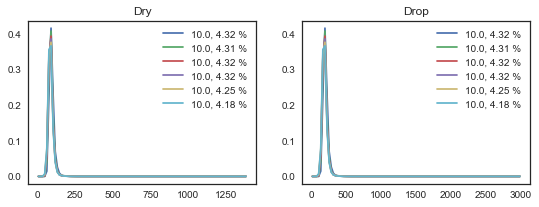

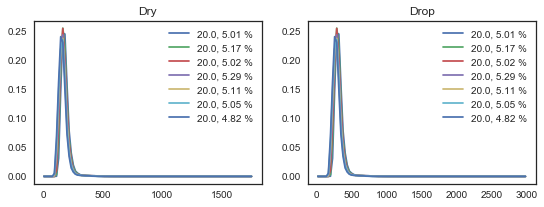

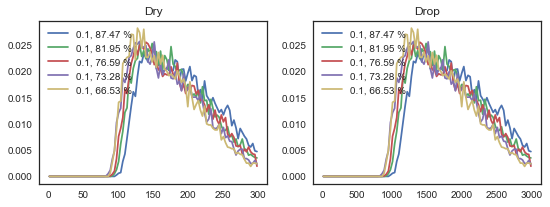

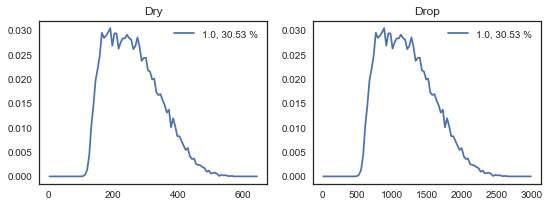

In [10]:
histograms = {}



for source in data:
    print source
    histograms[source] = {}
    
    for conc in data[source]:
        fig = figure(figsize=(9, 3))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)        

        histograms[source][conc] = {}
        for ds_name in sorted(data[source][str(conc)].keys()):
            data_ds = data[source][str(conc)][ds_name]
            
            residue_to_drop = lambda d_residue: float(1/(float(conc)*1E-2))**(1/3.)*d_residue
            drop_to_residue = lambda d_drop: (float(conc)*1E-2)**(1/3.)*d_drop
            
            I = data_sel[source][conc][ds_name]["I"]
            d = ray2nm[source](I**(1/6.))
            H, d_edges = histogram(d, bins=100, range=(0, drop_to_residue(3000.)))
            
            # Number of frames of integration
            nframes = data_ds["x"].shape[0]
            # Normalise histogram (per frame)
            H = H/float(nframes)
            
            d_centers = d_edges[:-1] + (d_edges[1]-d_edges[0])/2.
            Hv = H*velocity[source](d_centers)
    
            d_drop_centers = residue_to_drop(d_centers)
            
            histograms[source][conc][ds_name] = {}
            histograms[source][conc][ds_name]["H"] = H
            histograms[source][conc][ds_name]["H_velocity_corrected"] = Hv
            histograms[source][conc][ds_name]["d_centers"] = d_centers
            histograms[source][conc][ds_name]["d_drop_centers"] = d_drop_centers
            histograms[source][conc][ds_name]["d"] = d
            histograms[source][conc][ds_name]["d_drop"] = residue_to_drop(d)
                    
            if source == "ESI":
                flow_rate = 66. * 1E-6 / 60. # [ml/sec] nominal 66 nl/min
            else:
                flow_rate = asarray(data_ds["Flow Rate 1 [nl/min]"]) * 1E-6 / 60. # [ml/sec]
            flow_rate_V_expected = flow_rate * float(conc) / 100.

            # Area under Gaussian for sampled field of view
            sampled_fraction = data_beam[source][conc][ds_name]["sampled_fraction"]            
            # Sucrose ball volumes
            Vd = 4/3. * pi * (d_centers*1E-9/2.)**3
            
            flow_rate_V_measured = (Hv * Vd).sum() / (pix_to_um(L)*1E-6) / sampled_fraction * 1E6 # m3/s = 1000 l/s = 1000 x 1000 ml/s
            transmission = flow_rate_V_measured/flow_rate_V_expected
            #print flow_rate_V_measured , flow_rate_V_expected
            #print "Transmission: %.2e" % ()
            
            ax1.plot(d_centers, H/float(H.sum()), "-", label="%.1f, %.2f %%" % (float(conc), transmission*100))
            ax2.plot(d_drop_centers, H/float(H.sum()), "-", label="%.1f, %.2f %%" % (float(conc), transmission*100))

            #ax1.plot(d_centers, Hv/float(Hv.sum()), "-")
            #ax2.plot(d_drop_centers, Hv/float(Hv.sum()), "-", legend="%.2f %%" % (transmission*100))
    
        ax1.set_title("Dry")
        ax1.legend()
        ax2.set_title("Drop")
        ax2.legend()

## Plots for manuscript

In [11]:
plot_data = {}

### 1) MSI data

(15.0, 2984.9999999999995)
(15.0, 2985.0)


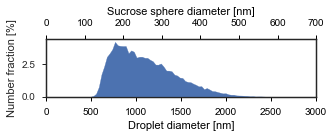

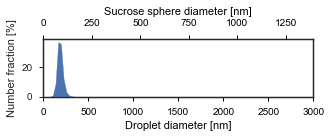

In [12]:
# Choosing data set with highest laser power
sources = ["GDVN", "ESI"]
ds_names = ["Data385_20160909", "Data337_20160906"]
concs = [1., 10]
colors = sns.color_palette()

residue_to_drop = lambda d_residue, conc: float(1/(float(conc)*1E-2))**(1/3.)*d_residue

for ds_name, source, conc in zip(ds_names, sources, concs):
    fig = figure(figsize=(5,2))
    ax = fig.add_axes([0.15, 0.3, 0.75, 0.4])
        
    H = histograms[source][str(conc)][ds_name]["H_velocity_corrected"].copy()
    d_drop_centers = histograms[source][str(conc)][ds_name]["d_drop_centers"]
    
    H_number_fraction = H/float(H.sum())
    print(d_drop_centers.min(), d_drop_centers.max())
    
    ax.fill_between(d_drop_centers, 0, H_number_fraction*100.,
                    label=source, alpha=1., color='C0', zorder=5)
        
    ax.set_xticks(arange(0, 3000+500, 500))
    ax.set_ylabel("Number fraction [%]")  
    ax.set_xlim(0, 3000)
        
    if source == "ESI":
        residue_ticks = np.asarray([0, 250, 500, 750, 1000, 1250])
    elif source == "GDVN":
        residue_ticks = np.asarray([0, 100, 200, 300, 400, 500, 600, 700])
            
    residue_tick_labels = ["%i" % _i for _i in residue_ticks]
    residue_tick_locations = [residue_to_drop(_d, conc) for _d in residue_ticks]

    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())

    ax_top.set_xticks(residue_tick_locations)
    ax_top.set_xticklabels(residue_tick_labels)
    ax_top.set_xlabel("Sucrose sphere diameter [nm]", color='k')
    ax.set_xlabel("Droplet diameter [nm]", color='k')
    ax_top.tick_params(length=4)
    ax_top.tick_params('x', colors='k')
    ax.tick_params(length=4)
    ax.tick_params('x', colors='k')
        
    ax.set_ylim(0, None)
    
    fig.savefig("fig2_d_droplets_msi_%s.png" % source, dpi=400)
    
    

(15.0, 2985.0)
(15.0, 2984.9999999999995)


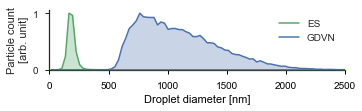

In [21]:
# Choosing data set with highest laser power
ds_names = ["Data337_20160906","Data385_20160909"]
concs = [10, 1.]
sources = ["ESI", "GDVN"]
colors = sns.color_palette()[:2][::-1]

residue_to_drop = lambda d_residue, conc: float(1/(float(conc)*1E-2))**(1/3.)*d_residue

fig = figure(figsize=(5,1.5))
ax = fig.add_axes([0.13, 0.35, 0.82, 0.55])

plot_data['msi'] = {}

for ds_name, source, conc, color in zip(ds_names, sources, concs, colors):
        
    H = histograms[source][str(conc)][ds_name]["H_velocity_corrected"].copy()
    d_drop_centers = histograms[source][str(conc)][ds_name]["d_drop_centers"]
    
    #H_number_fraction = H/float(H.sum())
    H_number_fraction = H/float(H.max())
    print(d_drop_centers.min(), d_drop_centers.max())

    if source == "ESI":
        label = "ES"
    else:
        label = source
    
    ax.plot(d_drop_centers, H_number_fraction, color=color, lw=1.5, label=label)
    ax.fill_between(d_drop_centers, 0, H_number_fraction,
                    alpha=0.3, color=color, zorder=5)
        
    ax.set_xticks(arange(0, 2500+500, 500))
    ax.set_ylabel("Particle count\n [arb. unit]")  
    ax.set_xlim(0, 2500)
        
    if source == "ESI":
        residue_ticks = np.asarray([0, 250, 500, 750, 1000, 1250])
    elif source == "GDVN":
        residue_ticks = np.asarray([0, 100, 200, 300, 400, 500, 600, 700])
            
    residue_tick_labels = ["%i" % _i for _i in residue_ticks]
    residue_tick_locations = [residue_to_drop(_d, conc) for _d in residue_ticks]

    #ax_top = ax.twiny()
    #ax_top.set_xlim(ax.get_xlim())

    #ax_top.set_xticks(residue_tick_locations)
    #ax_top.set_xticklabels(residue_tick_labels)
    #ax_top.set_xlabel("Sucrose sphere diameter [nm]", color='k')
    ax.set_xlabel("Droplet diameter [nm]", color='k')
    #ax_top.tick_params(length=4)
    #ax_top.tick_params('x', colors='k')
    ax.tick_params(length=4)
    ax.tick_params('x', colors='k')
    
    sns.despine()
    
    ax.set_ylim(0, None)
    
    ax.legend()
    
    plot_data['msi'][source] = {
        'd' : d_drop_centers,
        'H' : H_number_fraction,
    }

fig.savefig("../fig2a_droplets_msi.png", dpi=400)

### 2) XFEL data

In [14]:
xfel_data = {'ESI' : {}, 'GDVN' : {}}
with h5py.File('./xfel_data/sucrose_amol3116_run142_gdvn.h5', 'r') as f:
    xfel_data['GDVN']['d_drop'] = asarray(f['droplet_diameter_nm'])
    xfel_data['GDVN']['conc']   = asarray(f['sucrose_conc'])*100.
    
with h5py.File('./xfel_data/sucrose_amol3416_run38_esi.h5', 'r') as f:
    xfel_data['ESI']['d_drop'] = asarray(f['droplet_diameter_nm'])
    xfel_data['ESI']['conc']   = asarray(f['sucrose_conc'])*100.
    

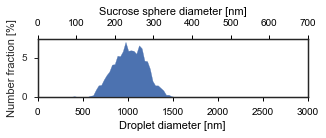

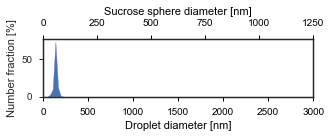

In [15]:
# Choosing data set with highest laser power
sources = ["GDVN", "ESI"]
colors = sns.color_palette()


for source in sources:
    conc = xfel_data[source]['conc']
    d_drop = xfel_data[source]['d_drop']
    #d_suc  = xfel_data[source]['d_suc']
    
    fig = figure(figsize=(5,2))
    ax = fig.add_axes([0.15, 0.3, 0.75, 0.4])

    H, d_drop_edges = histogram(d_drop, bins=100, range=(0, 3000))
    d_drop_centers = d_drop_edges[:-1] + (d_drop_edges[1]-d_drop_edges[0])/2.
    
    H_number_fraction = H/float(H.sum())*100.
    
    ax.fill_between(d_drop_centers, 0, H_number_fraction,
                    label=source, alpha=1., color='C0', zorder=5)
        
    ax.set_xticks(arange(0, 3000+500, 500))
    ax.set_ylabel("Number fraction [%]")  
    ax.set_xlim(0, 3000)
        
    if source == "ESI":
        residue_ticks = np.asarray([0, 250, 500, 750, 1000, 1250])
    elif source == "GDVN":
        residue_ticks = np.asarray([0, 100, 200, 300, 400, 500, 600, 700])
            
    residue_tick_labels = ["%i" % _i for _i in residue_ticks]
    residue_tick_locations = [residue_to_drop(_d, conc) for _d in residue_ticks]

    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())

    ax_top.set_xticks(residue_tick_locations)
    ax_top.set_xticklabels(residue_tick_labels)
    ax_top.set_xlabel("Sucrose sphere diameter [nm]", color='k')
    ax.set_xlabel("Droplet diameter [nm]", color='k')
    ax_top.tick_params(length=4)
    ax_top.tick_params('x', colors='k')
    ax.tick_params(length=4)
    ax.tick_params('x', colors='k')
        
    ax.set_ylim(0, None)
    
    fig.savefig("fig2_d_droplets_xfel_%s.png" % source, dpi=400)

(15.0, 2985.0)
(15.0, 2985.0)


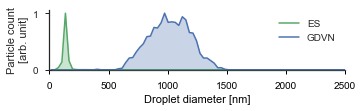

In [19]:
# Choosing data set with highest laser power
sources = ["ESI", "GDVN"]
colors = sns.color_palette()[:2][::-1]

fig = figure(figsize=(5,1.5))
ax = fig.add_axes([0.13, 0.35, 0.82, 0.55])

plot_data['xfel'] = {}

for ds_name, source, conc, color in zip(ds_names, sources, concs, colors):
    conc = xfel_data[source]['conc']
    d_drop = xfel_data[source]['d_drop']
        
    H, d_drop_edges = histogram(d_drop, bins=100, range=(0, 3000))
    d_drop_centers = d_drop_edges[:-1] + (d_drop_edges[1]-d_drop_edges[0])/2.

    #H_number_fraction = H/float(H.sum())
    H_number_fraction = H/float(H.max())
    print(d_drop_centers.min(), d_drop_centers.max())
    
    if source == "ESI":
        label = "ES"
    else:
        label = source
    
    ax.plot(d_drop_centers, H_number_fraction, color=color, lw=1.5, label=label)
    ax.fill_between(d_drop_centers, 0, H_number_fraction,
                    alpha=0.3, color=color, zorder=5)
      
    ax.set_xticks(arange(0, 2500+500, 500))
    ax.set_ylabel("Particle count\n [arb. unit]")  
    ax.set_xlim(0, 2500)
        
    if source == "ESI":
        residue_ticks = np.asarray([0, 250, 500, 750, 1000, 1250])
    elif source == "GDVN":
        residue_ticks = np.asarray([0, 100, 200, 300, 400, 500, 600, 700])
            
    residue_tick_labels = ["%i" % _i for _i in residue_ticks]
    residue_tick_locations = [residue_to_drop(_d, conc) for _d in residue_ticks]

    #ax_top = ax.twiny()
    #ax_top.set_xlim(ax.get_xlim())

    #ax_top.set_xticks(residue_tick_locations)
    #ax_top.set_xticklabels(residue_tick_labels)
    #ax_top.set_xlabel("Sucrose sphere diameter [nm]", color='k')
    ax.set_xlabel("Droplet diameter [nm]", color='k')
    #ax_top.tick_params(length=4)
    #ax_top.tick_params('x', colors='k')
    ax.tick_params(length=4)
    ax.tick_params('x', colors='k')
    
    sns.despine()
    
    ax.set_ylim(0, None)
    
    ax.legend()
    
    plot_data['xfel'][source] = {
        'd' : d_drop_centers,
        'H' : H_number_fraction,
    }
    
fig.savefig("../fig2b_droplets_xfel.png", dpi=400)

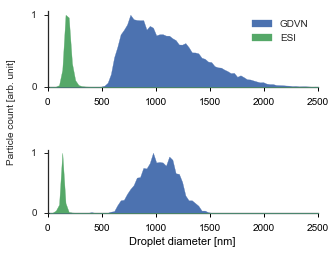

In [96]:
# Plot all together
colors = sns.color_palette()
methods = ['msi', 'xfel']

fig = figure(figsize=(5,3.5))
ax2 = fig.add_axes([0.15, 0.15, 0.75, 0.25])
ax1 = fig.add_axes([0.15, 0.15+0.3+0.2, 0.75, 0.3])

axs = [ax1, ax2]

for ax, method in zip(axs, methods):
    for source, color in zip(plot_data[method], colors):
        d = plot_data[method][source]['d']
        H = plot_data[method][source]['H']
        ax.fill_between(d, 0, H,
                        label=source, alpha=1., color=color, zorder=5)
        
        ax.set_xticks(arange(0, 2500+500, 500))
        ax.set_yticks([0, 1])
        ax.set_xlim(0, 2500)
        
        ax.tick_params(length=4)
        ax.tick_params('x', colors='k')
    
        sns.despine()
    
        ax.set_ylim(0, None)
    
ax1.legend()

#ax.set_ylabel("Particle count\n [arb. unit]")  
fig.text(0.05, 0.55, "Particle count [arb. unit]", rotation=90, ha='center', va='center')
ax.set_xlabel("Droplet diameter [nm]", color='k')
    
fig.savefig("../fig2_droplets.png", dpi=400)